<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%206/l1_0.0005%20l2_0.0005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


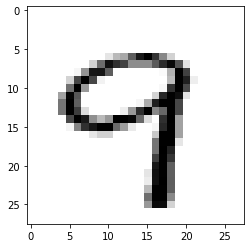

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

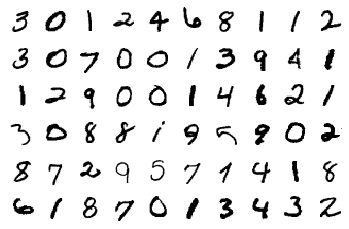

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # i/p= 28 o/p=26 r=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # i/p=26  o/p=24 r=5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.05),
            
            nn.MaxPool2d(kernel_size=(2,2)), # i/p=24  o/p=12 r=6  

            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=12  o/p=10 r=10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),
            

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=10  o/p=8 r=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=8  o/p=6 r=18
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=6  o/p=4 r=22
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=4  o/p=2 r=26
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),


        ) 

    def forward(self, x):

        x = self.convblock1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_loss(model, data, factor):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def misclassified_images(misclassify):
  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(25): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
      title = "Predicted: "+ str(misclassify[i][1][0].data.cpu().numpy())+" Target: "+ str(misclassify[i][2].data.cpu().numpy())
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassify = []

def train(model, device, train_loader, optimizer, epoch, use_l1 = False,l1_factor = 0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if use_l1 == True:
      loss += L1_loss(model,data,factor=l1_factor)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # output is the probability for each class
            
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassify.append([data[i],pred[i],target[i]])
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # print("o === ",pred,"-------target = ",target,"output",output.shape)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # print(len(misclassify))
    # print(misclassify[0][0].size()) 
    test_acc.append(100. * correct / len(test_loader.dataset))

    # j=0
    # fig = plt.figure(figsize=(15,15)) 
    # for i in range(25): 
    #     ax = fig.add_subplot(7,4 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
    #     plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
    #     title = "predicted: "+ str(misclassify[i][1].data.cpu().numpy())+"target: "+ str(misclassify[i][2].data.cpu().numpy())
    #     ax.set_title(title) # give the class of the image as its title
    #     j+=1      
    # plt.show()

# Let's Train and test our model

In [12]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.1248491033911705 Batch_id=468 Accuracy=91.35: 100%|██████████| 469/469 [00:12<00:00, 39.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9843/10000 (98.43%)

EPOCH: 1 lr =  0.01


Loss=0.12048003822565079 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:11<00:00, 39.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9863/10000 (98.63%)

EPOCH: 2 lr =  0.01


Loss=0.0338473804295063 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9904/10000 (99.04%)

EPOCH: 3 lr =  0.01


Loss=0.029673777520656586 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9907/10000 (99.07%)

EPOCH: 4 lr =  0.01


Loss=0.043181609362363815 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 38.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9905/10000 (99.05%)

EPOCH: 5 lr =  0.01


Loss=0.013007651083171368 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 39.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)

EPOCH: 6 lr =  0.001


Loss=0.010996405966579914 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:11<00:00, 39.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 7 lr =  0.001


Loss=0.004233817104250193 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 8 lr =  0.0001


Loss=0.00612438702955842 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 9 lr =  0.0001


Loss=0.003409435274079442 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 39.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 10 lr =  0.0001


Loss=0.08228429406881332 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 40.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 11 lr =  0.0001


Loss=0.011262754909694195 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 12 lr =  1e-05


Loss=0.08615168184041977 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9945/10000 (99.45%)

EPOCH: 13 lr =  1e-05


Loss=0.003987675067037344 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 39.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 14 lr =  1e-05


Loss=0.0030587364453822374 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 40.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 15 lr =  1e-05


Loss=0.005059778690338135 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 16 lr =  1e-05


Loss=0.05169372633099556 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 17 lr =  1e-05


Loss=0.015267456881701946 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 18 lr =  1e-05


Loss=0.02834588848054409 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 19 lr =  1e-05


Loss=0.05864102765917778 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 20 lr =  1e-05


Loss=0.07211160659790039 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 21 lr =  1e-05


Loss=0.008977527730166912 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 22 lr =  1e-05


Loss=0.06698060780763626 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH: 23 lr =  1e-05


Loss=0.020801270380616188 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)

EPOCH: 24 lr =  1e-05


Loss=0.041405413299798965 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 48.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 25 lr =  1e-05


Loss=0.030810048803687096 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 40.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 26 lr =  1e-05


Loss=0.053606029599905014 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 27 lr =  1e-05


Loss=0.040296319872140884 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 49.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 28 lr =  1e-05


Loss=0.01569380797445774 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 29 lr =  1e-05


Loss=0.011656786315143108 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 30 lr =  1e-05


Loss=0.047641415148973465 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 31 lr =  1e-05


Loss=0.011713191866874695 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 32 lr =  1e-05


Loss=0.025858908891677856 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 40.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 33 lr =  1e-05


Loss=0.0074237436056137085 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 34 lr =  1e-05


Loss=0.002530718920752406 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 35 lr =  1e-05


Loss=0.005465304013341665 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 46.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 36 lr =  1e-05


Loss=0.05090633034706116 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 37 lr =  1e-05


Loss=0.017025405541062355 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 40.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 38 lr =  1e-05


Loss=0.027492612600326538 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 39 lr =  1e-05


Loss=0.007879872806370258 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.72it/s]



Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)



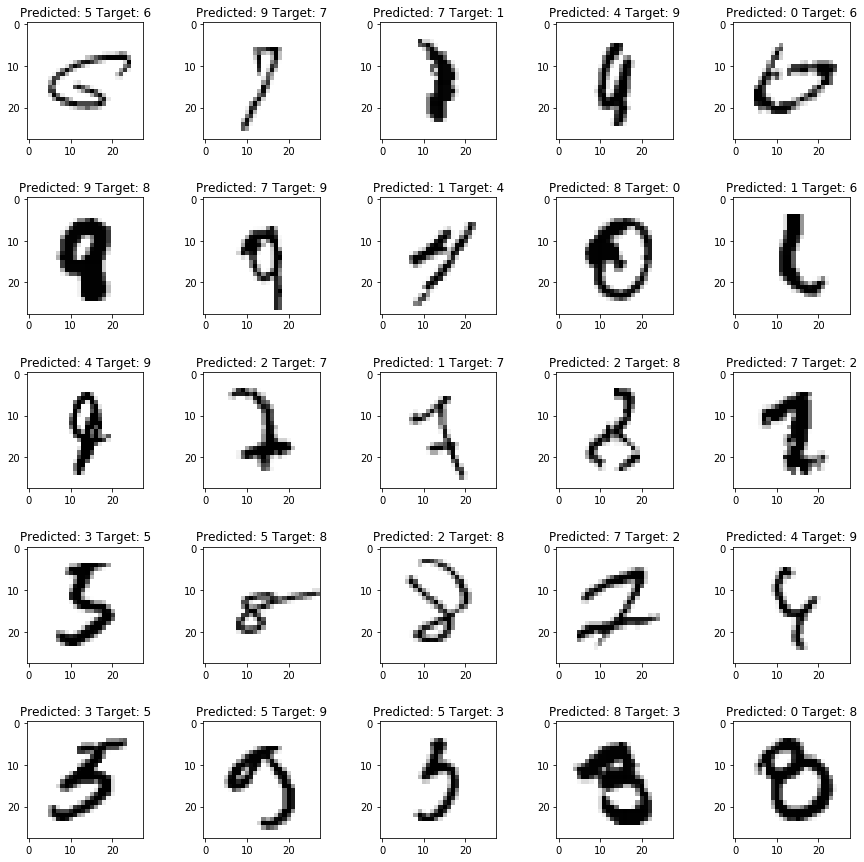

In [13]:
misclassified_images(misclassify)

In [0]:
train_acc_without_l1_l2 = train_acc.copy()
train_loss_without_l1_l2 = train_losses.copy()
test_acc_without_l1_l2 = test_acc.copy()
test_loss_without_l1_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

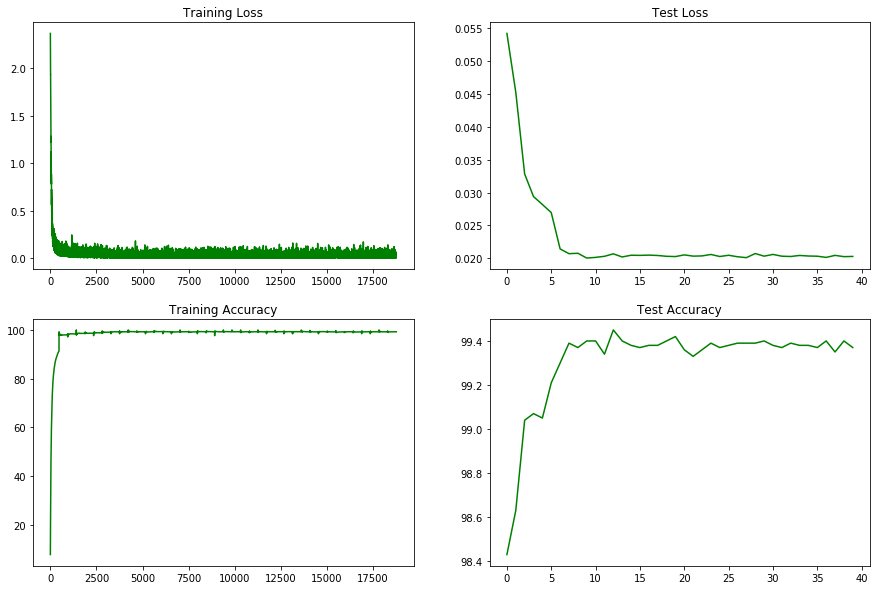

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g')
axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1**

In [54]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch,use_l1 = True,l1_factor=0.0005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.11153043806552887 Batch_id=468 Accuracy=90.81: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9798/10000 (97.98%)

EPOCH: 1 lr =  0.01


Loss=0.26595520973205566 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9857/10000 (98.57%)

EPOCH: 2 lr =  0.01


Loss=0.023317541927099228 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 42.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9888/10000 (98.88%)

EPOCH: 3 lr =  0.01


Loss=0.14239491522312164 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9903/10000 (99.03%)

EPOCH: 4 lr =  0.01


Loss=0.04529494047164917 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9890/10000 (98.90%)

EPOCH: 5 lr =  0.01


Loss=0.04611063748598099 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

EPOCH: 6 lr =  0.001


Loss=0.026305917650461197 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9922/10000 (99.22%)

EPOCH: 7 lr =  0.001


Loss=0.02387937903404236 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 8 lr =  0.0001


Loss=0.008673716336488724 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 40.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 9 lr =  0.0001


Loss=0.024098608642816544 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 10 lr =  0.0001


Loss=0.00899023562669754 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

EPOCH: 11 lr =  0.0001


Loss=0.009306138381361961 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 12 lr =  1e-05


Loss=0.029248598963022232 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 13 lr =  1e-05


Loss=0.029669417068362236 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9926/10000 (99.26%)

EPOCH: 14 lr =  1e-05


Loss=0.014948884956538677 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 15 lr =  1e-05


Loss=0.03357700631022453 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 16 lr =  1e-05


Loss=0.023230794817209244 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 17 lr =  1e-05


Loss=0.018931560218334198 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 18 lr =  1e-05


Loss=0.08106166869401932 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 19 lr =  1e-05


Loss=0.015646614134311676 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 20 lr =  1e-05


Loss=0.01592760905623436 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 21 lr =  1e-05


Loss=0.03744285926222801 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH: 22 lr =  1e-05


Loss=0.07741698622703552 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 23 lr =  1e-05


Loss=0.10233175754547119 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

EPOCH: 24 lr =  1e-05


Loss=0.01652732864022255 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 25 lr =  1e-05


Loss=0.09190785884857178 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 40.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 26 lr =  1e-05


Loss=0.02673216164112091 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 27 lr =  1e-05


Loss=0.016717707738280296 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 28 lr =  1e-05


Loss=0.04847437143325806 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH: 29 lr =  1e-05


Loss=0.03701281175017357 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 30 lr =  1e-05


Loss=0.015272567979991436 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 31 lr =  1e-05


Loss=0.024910887703299522 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 32 lr =  1e-05


Loss=0.027630940079689026 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 33 lr =  1e-05


Loss=0.009108329191803932 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 40.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 34 lr =  1e-05


Loss=0.0690666064620018 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 41.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 35 lr =  1e-05


Loss=0.0147499805316329 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 36 lr =  1e-05


Loss=0.02738766372203827 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 37 lr =  1e-05


Loss=0.01670077256858349 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 38 lr =  1e-05


Loss=0.06507179886102676 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 39.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 39 lr =  1e-05


Loss=0.011559437960386276 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]



Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)



In [55]:
len(misclassify)

71

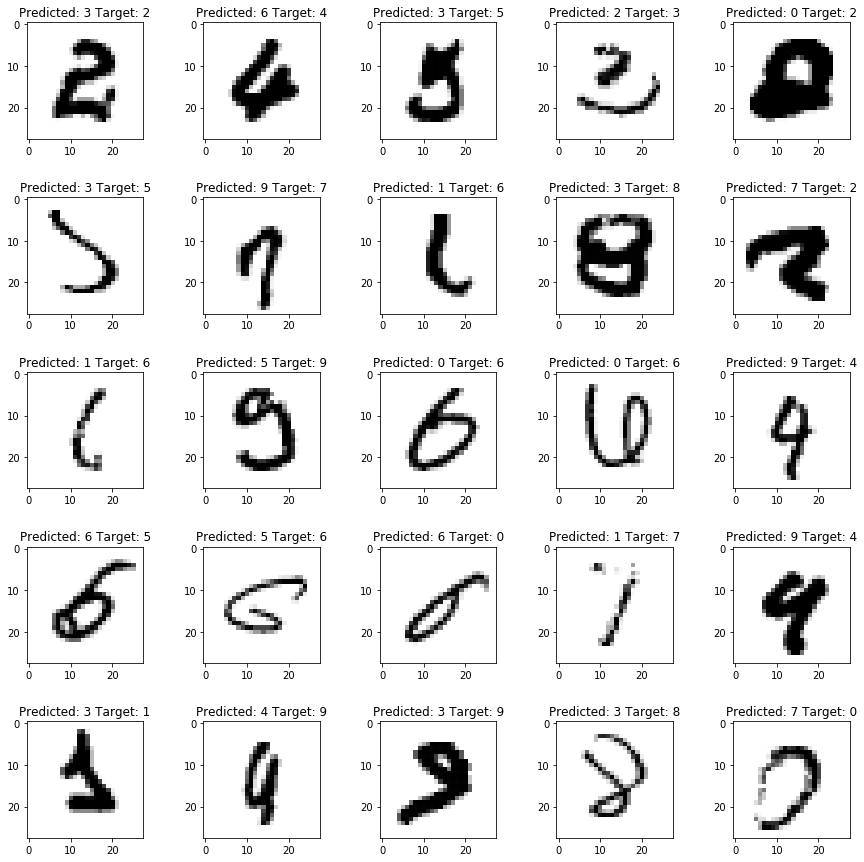

In [56]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1 = train_acc.copy()
train_loss_with_l1 = train_losses.copy()
test_acc_with_l1 = test_acc.copy()
test_loss_with_l1 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

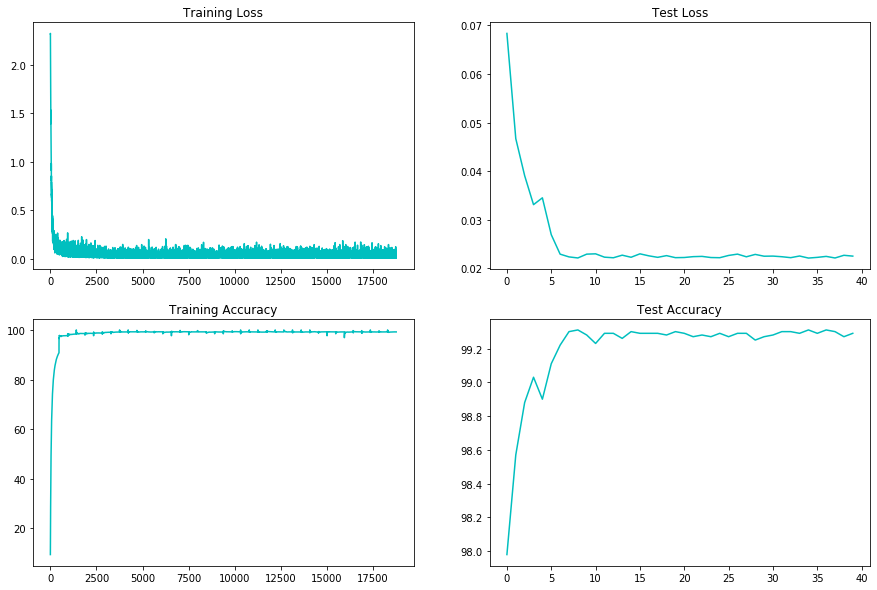

In [58]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_with_l1,color='c')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1,color='c')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1,color='c')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1,color='c')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L2**

In [60]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0005)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.0530388318002224 Batch_id=468 Accuracy=91.80: 100%|██████████| 469/469 [00:11<00:00, 47.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0620, Accuracy: 9816/10000 (98.16%)

EPOCH: 1 lr =  0.01


Loss=0.06597719341516495 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9853/10000 (98.53%)

EPOCH: 2 lr =  0.01


Loss=0.044230446219444275 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.93%)

EPOCH: 3 lr =  0.01


Loss=0.025737708434462547 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 41.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.07%)

EPOCH: 4 lr =  0.01


Loss=0.0871286615729332 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

EPOCH: 5 lr =  0.01


Loss=0.07979858666658401 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:11<00:00, 48.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9902/10000 (99.02%)

EPOCH: 6 lr =  0.001


Loss=0.025104327127337456 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 7 lr =  0.001


Loss=0.0244557186961174 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 8 lr =  0.0001


Loss=0.07310750335454941 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 9 lr =  0.0001


Loss=0.015525092370808125 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 47.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

EPOCH: 10 lr =  0.0001


Loss=0.010603968985378742 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

EPOCH: 11 lr =  0.0001


Loss=0.0476524643599987 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 12 lr =  1e-05


Loss=0.04042598232626915 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)

EPOCH: 13 lr =  1e-05


Loss=0.03954903408885002 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 14 lr =  1e-05


Loss=0.012415662407875061 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 15 lr =  1e-05


Loss=0.012369896285235882 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 16 lr =  1e-05


Loss=0.06482375413179398 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 17 lr =  1e-05


Loss=0.012419615872204304 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 18 lr =  1e-05


Loss=0.020685404539108276 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 19 lr =  1e-05


Loss=0.01575801707804203 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 38.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 20 lr =  1e-05


Loss=0.08094615489244461 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 39.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 21 lr =  1e-05


Loss=0.07298775017261505 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 22 lr =  1e-05


Loss=0.021918660029768944 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 23 lr =  1e-05


Loss=0.03205673769116402 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 24 lr =  1e-05


Loss=0.012809197418391705 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 39.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 25 lr =  1e-05


Loss=0.01619669795036316 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 40.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 26 lr =  1e-05


Loss=0.09465832263231277 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 27 lr =  1e-05


Loss=0.016617722809314728 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 50.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 28 lr =  1e-05


Loss=0.01947508193552494 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 29 lr =  1e-05


Loss=0.029732979834079742 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 30 lr =  1e-05


Loss=0.01715460978448391 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 31 lr =  1e-05


Loss=0.07638030499219894 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 32 lr =  1e-05


Loss=0.009377707727253437 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 33 lr =  1e-05


Loss=0.025886105373501778 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 34 lr =  1e-05


Loss=0.02139020524919033 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 35 lr =  1e-05


Loss=0.025372764095664024 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

EPOCH: 36 lr =  1e-05


Loss=0.004752357956022024 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 37 lr =  1e-05


Loss=0.0410873107612133 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 38 lr =  1e-05


Loss=0.012716114521026611 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 39 lr =  1e-05


Loss=0.007377321366220713 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]



Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)



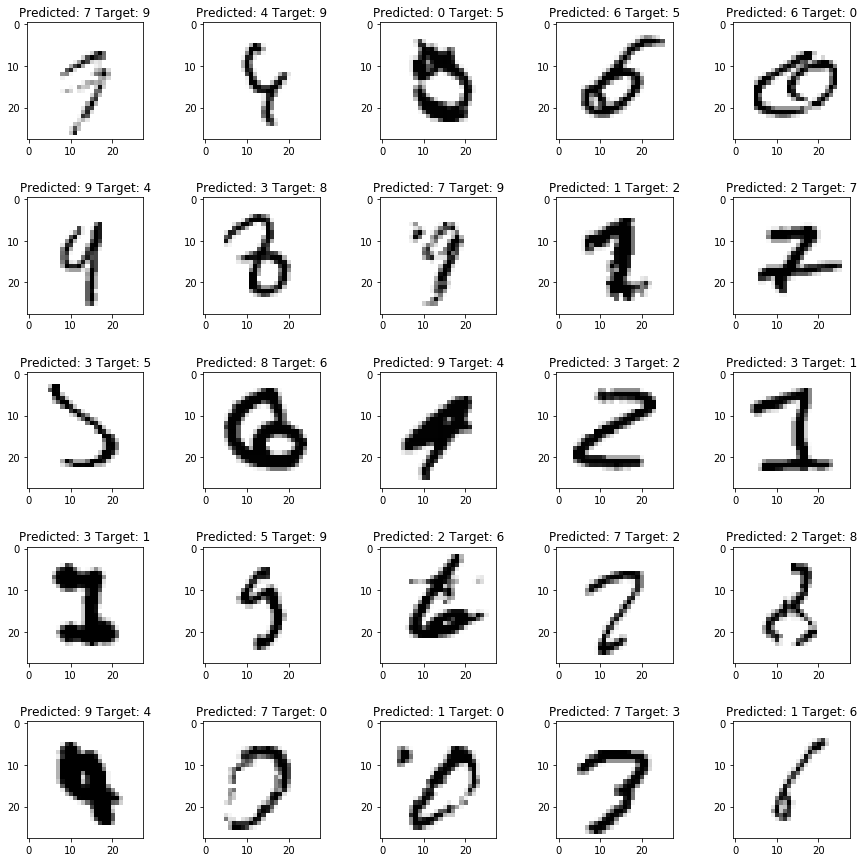

In [61]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l2 = train_acc.copy()
train_loss_with_l2 = train_losses.copy()
test_acc_with_l2 = test_acc.copy()
test_loss_with_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

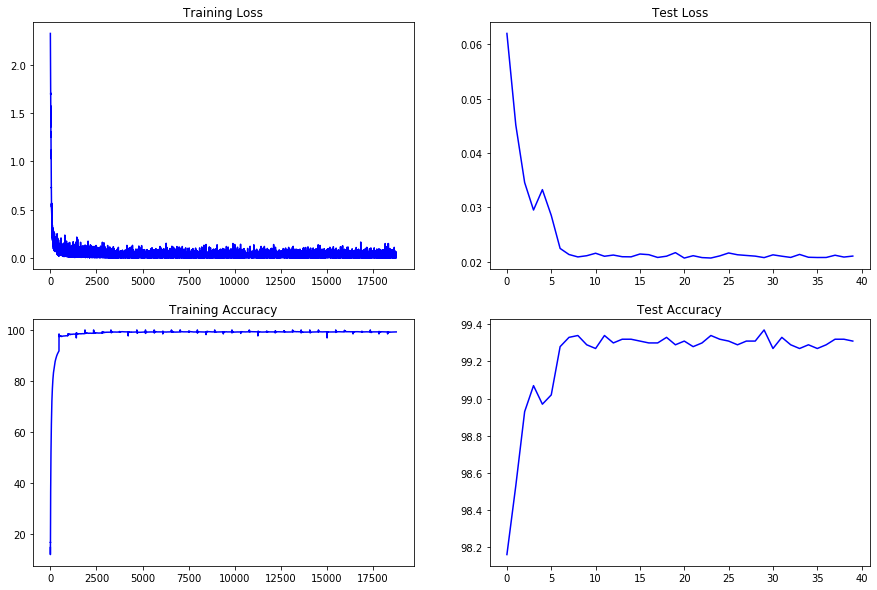

In [63]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l2,color = 'b')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l2,color = 'b')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l2,color = 'b')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l2,color = 'b')

axs[1, 1].set_title("Test Accuracy")

In [0]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1 and L2**

In [65]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0005)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, use_l1 = True,l1_factor=0.0005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.062077250331640244 Batch_id=468 Accuracy=90.84: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9777/10000 (97.77%)

EPOCH: 1 lr =  0.01


Loss=0.19339337944984436 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9850/10000 (98.50%)

EPOCH: 2 lr =  0.01


Loss=0.10261734575033188 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9868/10000 (98.68%)

EPOCH: 3 lr =  0.01


Loss=0.05278826877474785 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9879/10000 (98.79%)

EPOCH: 4 lr =  0.01


Loss=0.05869699642062187 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9904/10000 (99.04%)

EPOCH: 5 lr =  0.01


Loss=0.21548375487327576 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9899/10000 (98.99%)

EPOCH: 6 lr =  0.001


Loss=0.04052572324872017 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9916/10000 (99.16%)

EPOCH: 7 lr =  0.001


Loss=0.007923854514956474 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 8 lr =  0.0001


Loss=0.03345394879579544 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

EPOCH: 9 lr =  0.0001


Loss=0.13792040944099426 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9917/10000 (99.17%)

EPOCH: 10 lr =  0.0001


Loss=0.03545411676168442 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 36.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)

EPOCH: 11 lr =  0.0001


Loss=0.05416450276970863 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 41.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 12 lr =  1e-05


Loss=0.05772148817777634 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 13 lr =  1e-05


Loss=0.01608080044388771 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)

EPOCH: 14 lr =  1e-05


Loss=0.018932048231363297 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 42.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99.23%)

EPOCH: 15 lr =  1e-05


Loss=0.011768543161451817 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH: 16 lr =  1e-05


Loss=0.01571762003004551 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 17 lr =  1e-05


Loss=0.09112702310085297 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 18 lr =  1e-05


Loss=0.10077156126499176 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9921/10000 (99.21%)

EPOCH: 19 lr =  1e-05


Loss=0.034226980060338974 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 40.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 20 lr =  1e-05


Loss=0.014080040156841278 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 21 lr =  1e-05


Loss=0.017795482650399208 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 42.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)

EPOCH: 22 lr =  1e-05


Loss=0.027090877294540405 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 23 lr =  1e-05


Loss=0.008983911015093327 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9921/10000 (99.21%)

EPOCH: 24 lr =  1e-05


Loss=0.01120692864060402 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

EPOCH: 25 lr =  1e-05


Loss=0.03334793448448181 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99.23%)

EPOCH: 26 lr =  1e-05


Loss=0.014475608244538307 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9920/10000 (99.20%)

EPOCH: 27 lr =  1e-05


Loss=0.012571588158607483 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.20%)

EPOCH: 28 lr =  1e-05


Loss=0.015758056193590164 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9922/10000 (99.22%)

EPOCH: 29 lr =  1e-05


Loss=0.046762458980083466 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9922/10000 (99.22%)

EPOCH: 30 lr =  1e-05


Loss=0.035428237169981 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 31 lr =  1e-05


Loss=0.03425443917512894 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

EPOCH: 32 lr =  1e-05


Loss=0.02965158224105835 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

EPOCH: 33 lr =  1e-05


Loss=0.03206375241279602 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 42.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 34 lr =  1e-05


Loss=0.045421164482831955 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 35 lr =  1e-05


Loss=0.03378896415233612 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)

EPOCH: 36 lr =  1e-05


Loss=0.027771247550845146 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9920/10000 (99.20%)

EPOCH: 37 lr =  1e-05


Loss=0.023811351507902145 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9917/10000 (99.17%)

EPOCH: 38 lr =  1e-05


Loss=0.08147307485342026 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9918/10000 (99.18%)

EPOCH: 39 lr =  1e-05


Loss=0.08148782700300217 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]



Test set: Average loss: 0.0230, Accuracy: 9919/10000 (99.19%)



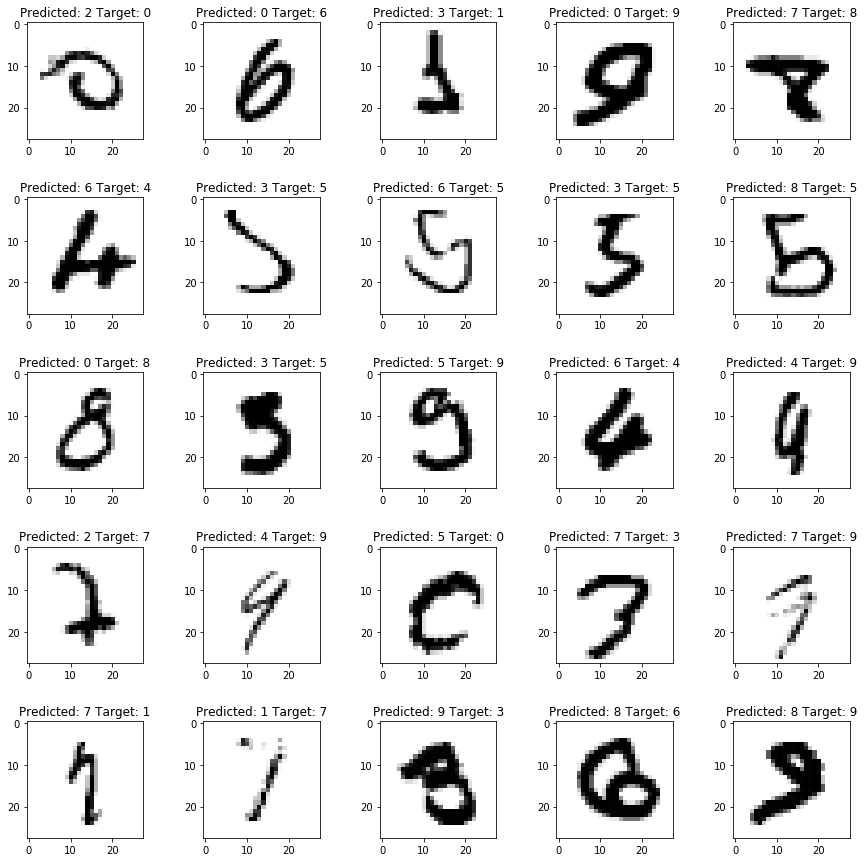

In [66]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1_l2 = train_acc.copy()
train_loss_with_l1_l2 = train_losses.copy()
test_acc_with_l1_l2 = test_acc.copy()
test_loss_with_l1_l2 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

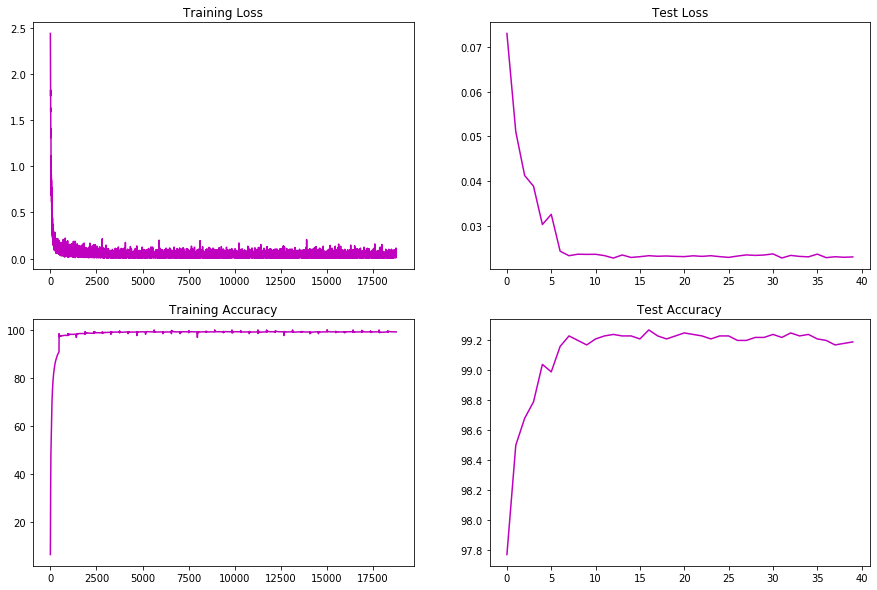

In [68]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l1_l2,color = 'm')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1_l2,color = 'm')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1_l2,color = 'm')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1_l2,color = 'm')

axs[1, 1].set_title("Test Accuracy")

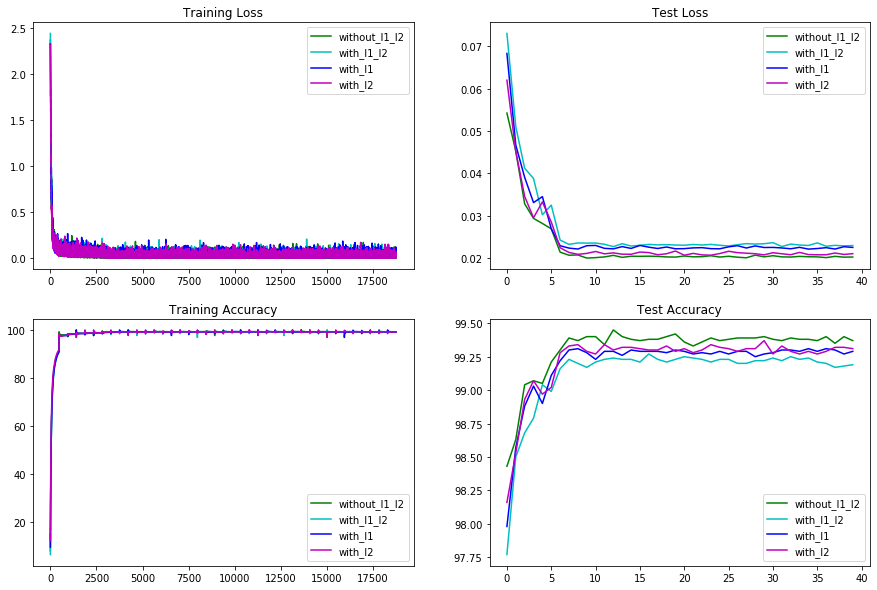

In [69]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0, 0].plot(train_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0, 0].plot(train_loss_with_l1,color = 'b',label="with_l1")
axs[0, 0].plot(train_loss_with_l2,color = 'm',label="with_l2")
axs[0, 0].set_title("Training Loss")
axs[0, 0].legend()
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1, 0].plot(train_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1, 0].plot(train_acc_with_l1,color = 'b',label="with_l1")
axs[1, 0].plot(train_acc_with_l2,color = 'm',label="with_l2")
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].legend()
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0, 1].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0, 1].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0, 1].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend()
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1, 1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1, 1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1, 1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend()

Text(0.5, 0.98, 'l1 = 0.0005, l2 = 0.0005')

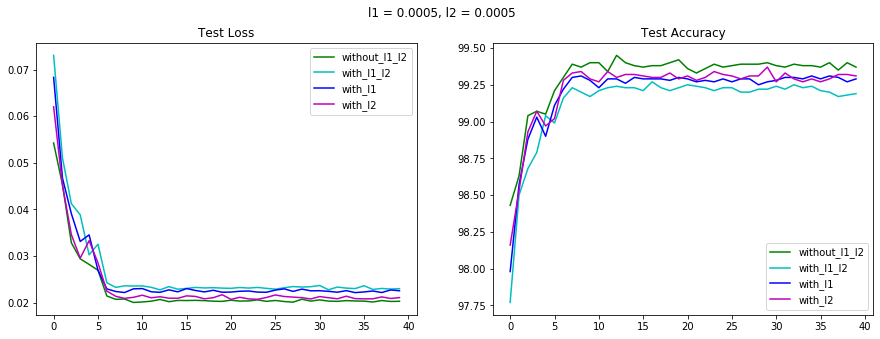

In [77]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1].set_title("Test Accuracy")
axs[1].legend()
fig.suptitle("l1 = 0.0005, l2 = 0.0005")